In [118]:
#Standard modules
import sys
import numpy as np
import yaml
import pandas
import gvar as gv
#Qiskit modules
from qiskit import IBMQ, QuantumCircuit, transpile, QuantumRegister, execute, ClassicalRegister
from qiskit.providers.ibmq import RunnerResult
from qiskit import Aer
from qiskit.providers import aer
from qiskit.providers.aer import noise
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector, Operator
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import plot_histogram

import datetime
#Project modules
sys.path.append('./modules/')
sys.path.append('./inputs/')
sys.path.append('./plots/')
import StatePrep as sprep
import DD_PassManager as dd_pm
import paulitwirlingpass as pts
from Z2analysis import nsites2nqubits
import Trotterization as Trot

# for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import Image
plt.rcParams["figure.autolayout"] = True
colors = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline

#For testing reload modules after edits
from importlib import reload
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
### get run parameters from YAML input file ###

stream = open('inputs/Z2_input_nairobi_7qubit_params1.yaml', 'r')
dict_in = yaml.safe_load(stream)
stream.close()

account_info = dict_in['account_info'] # dictionary of account information
backend_opts = dict_in['backend_opts']   # dictionary of machine/simulator choices
simulation_opts = dict_in['simulation_opts'] # dictionary of lattice-simulation parameters
runtime_opts = dict_in['runtime_opts'] # dictionary of runtime parameters

### transpilation parameters ###
initial_layout = simulation_opts['layout']['initial_layout']
### Lattice parameters ###
mass = simulation_opts['lattice_params']['mass']       #fermion mass in lattice-spacing units
nsites = simulation_opts['lattice_params']['nsites']   #must be even for staggered simulation
nqubits = nsites2nqubits(nsites)
print(nqubits, nsites)
### Time evolution ###
tf = simulation_opts['time_evolution']['tf']       # total time interval in lattice-spacing units
ntrotter = simulation_opts['time_evolution']['ntrotter'] # number of trotter steps
epsilon = tf/ntrotter                              # step size in lattice-spacing units
# print(twirl)
### Pauli Twirling ###
twirl = simulation_opts['pauli_twirling']['twirl'] 
twirl = False # if True, apply Pauli twirling
ntwirls = simulation_opts['pauli_twirling']['ntwirls'] # number of Pauli twirls

### dynamic decoupling ###
dd_method = simulation_opts['dynamic_decoupling']['method'] # if not none apply a given dynamic decoupling method

### Richardson ??? ###
richardson_level = simulation_opts['richardson_level'] # number of CNOTs for Richardson smearing


7 4


This is the state preparation circuit you do not need to address anything in here

In [98]:
def state_preparation(nq: int, mass: float, state_prep_type='simple', excite_loc=None, init_state=None):
    '''
    circuit to do state preparation
    
    arguments:
        nq (int): the number of working qubits in the simulation
        mass (float): the mass of the fermion
        state_prep_type (str): 'simple', 'vector', 'circuit'
    
    returns:
        qc (QuantumCircuit): the circuit that implements state preparation
    '''
    # check that the number of qubits is correct
    assert(((nq + 1) // 2 ) % 2 == 0)
    
    # prepare the quantum circuit object
    qc = QuantumCircuit(nq)
    
    # check that the state prep type works
    # pass vector state prep
    if state_prep_type is 'vector':
        assert(init_state is not None)
        qc.initialize(init_state, [i for i in range(nq)])
        return qc
    # simple initial state prep
    elif state_prep_type == 'simple':
        if nq == 3:
            qc.rx(np.pi / 3, 0)
            qc.cx(0, 1)
            qc.cx(0, 2)
            qc.x(2)
            qc.h(1)
        elif nq == 7:
            qc.h(2)
            qc.cx(2, 3)
            qc.cx(3, 4)
            qc.h([1, 3, 5])
            qc.x([2, 6])
        return qc
    elif state_prep_type is 'circuit':
        print('other team needs to have this done')
    else:
        print(f'{state_prep_type} is not implemented')

<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\gusta\AppData\Local\Temp\ipykernel_20040\1957853697.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if state_prep_type is 'vector':
C:\Users\gusta\AppData\Local\Temp\ipykernel_20040\1957853697.py:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif state_prep_type is 'circuit':


This is the circuit to build the various gates necessary for the first insertion of the current operator this splits the circuit

In [99]:
def make_current_insertion_operators(op_type: int=0):
    '''
    build the different current insertion operators
    
    parameters:
        op_type (int): allowed values 0 or 1 if 0 apply J0 else apply J1
    '''
    assert(op_type==0 or op_type==1)
    
    if op_type == 0:
        # define the qubits that correspond to the ancilla and the targets
        anc = 0
        site = 1
        # The quantum circuits we will use to turn into gates
        # qc_op1 has nothing applied to it 
        qc_op1 = QuantumCircuit(2)
        # turn the ancilla from |0> -> |+>
        qc_op1.h(anc)
        # turn the circuit into a gate
        J0_term1 = qc_op1.to_gate(label='J0_op1')
        # qc_op2 has Z applied to the site 
        qc_op2 = QuantumCircuit(2)
        # turn the ancilla from |0> -> |+>
        qc_op2.h(anc)
        # apply the CZ gate controlled on the ancilla
        ####################################
        qc_op2.cz(anc, site)
        ####################################
        # this turns qc_op2 into a gate
        J0_term2 = qc_op2.to_gate(label='J0_op2')
        return J0_term1, J0_term2
    elif op_type == 1:
        anc = 0
        work = [1, 2, 3]
        # qc_op1 applies XZY11
        qc_op1 = QuantumCircuit(4)
        # qc_op2 applies YZX11
        qc_op2 = QuantumCircuit(4)
        # qc_op3 applies 11XZY
        qc_op3 = QuantumCircuit(4)
        # qc_op3 applies 11YZX
        qc_op4 = QuantumCircuit(4)
        qc_ops = [qc_op1, qc_op2, qc_op3, qc_op4]
        # set the ancilla qubit into the |+> state
        for qc in qc_ops:
            qc.h(anc)
        ################################
        # apply XZY11
        qc_ops[0].cx(anc, work[0])
        qc_ops[0].cz(anc, work[1])
        qc_ops[0].cy(anc, work[2])
        ################################
        ################################
        # apply YZX11
        qc_ops[1].cy(anc, work[0])
        qc_ops[1].cz(anc, work[1])
        qc_ops[1].cx(anc, work[2])
        ################################
        ################################
        # apply 11XZY
        qc_ops[2].cx(anc, work[0])
        qc_ops[2].cz(anc, work[1])
        qc_ops[2].cy(anc, work[2])
        ################################
        ################################
        # apply 11YZX
        qc_ops[3].cy(anc, work[0])
        qc_ops[3].cz(anc, work[1])
        qc_ops[3].cx(anc, work[2])
        ################################
        return [qc_ops[i].to_gate(label=f'J1_op{i}') for i in range(len(qc_ops))]
    else:
        print(f'{op_type} is an unallowed choice for op_type')
    

In [100]:
def apply_basis_measurement(nqwork: int, op_type, quantum_circuit, qwork, qanc, cwork, canc):
    # apply a hadamard gate to the ancilla qubit to take from z basis to x basis for measurement
    quantum_circuit.h(qanc[0])
    if op_type == 0:
        #######
        # apply a measure command to all the working qubits
        quantum_circuit.measure(qwork, cwork)
        quantum_circuit.measure(qanc, canc)
        return quantum_circuit
        #######
    elif op_type == 1:
        basis1 = quantum_circuit.copy()
        basis2 = quantum_circuit.copy()
        #######
        for i in range(nqwork):
            # check if this is not a link
            if i % 2 == 0:
                if i % 4 == 0:
                    basis1.h(qwork[i])
                    basis2.sdg(qwork[i])
                    basis2.h(qwork[i])
                elif i % 4 == 2:
                    basis1.sdg(qwork[i])
                    basis1.h(qwork[i])
                    basis2.h(qwork[i])
        #######
        basis1.measure(qwork, cwork)
        basis1.measure(qanc, canc)
        basis2.measure(qwork, cwork)
        basis2.measure(qanc, canc)
        return basis1, basis2
    else:
        print(f'{op_type} is an unallowed choice for op_type')

In [101]:
def construct_quantum_circuits(nsites, ntime, epsilon, mass, init_state=None,
                               op1=0, op2=0, site=0):
    qwork, qanc = QuantumRegister(nsites * 2 - 1), QuantumRegister(1)
    cwork, canc = ClassicalRegister(nsites * 2 - 1), ClassicalRegister(1)
    qc = QuantumCircuit(qwork, qanc, cwork, canc)
    
    # state preparation
    qc.append(state_preparation(2 * nsites - 1, mass, state_prep_type='simple'), qwork)
    # make the different current insertion circuits
    if op1 == 0:
        J0terms = make_current_insertion_operators(op_type=op1)
        circuits = [qc, qc.copy()]
        for i in range(2):
            circuits[i].append(J0terms[i], [qanc[0], qwork[2 * site]])
    if op1 == 1:
        J1terms = make_current_insertion_operators(op_type=op1)
        if nsites == 2 or site==0:
            circuits = [qc, qc.copy()]
            circuits[0].append(J1terms[0], [qanc[0], qwork[0], qwork[1], qwork[2]])
            circuits[1].append(J1terms[1], [qanc[0], qwork[0], qwork[1], qwork[2]])
        elif site == nsites - 1:
            circuits = [qc, qc.copy()]
            circuits[0].append(J1terms[2], [qanc[0], qwork[-3], qwork[-2], qwork[-1]])
            circuits[0].append(J1terms[3], [qanc[0], qwork[-3], qwork[-2], qwork[-1]])
        else:
            circuits = [qc, qc.copy(), qc.copy(), qc.copy()]
            q3 = 2 * site
            q2 = q3 - 1
            q1 = q2 - 1
            q4 = q3 + 1
            q5 = q4 + 1
            circuits[0].append(J1terms[0], [qanc[0], qwork[q1], qwork[q2], qwork[q3]])
            circuits[1].append(J1terms[1], [qanc[0], qwork[q1], qwork[q2], qwork[q3]])
            circuits[2].append(J1terms[2], [qanc[0], qwork[q3], qwork[q4], qwork[q5]])
            circuits[3].append(J1terms[3], [qanc[0], qwork[q3], qwork[q4], qwork[q5]])
    # trotter evolution
    for circuit in circuits:
        circuit.append(Trot.trotter_evolution(nsites, epsilon, mass, ntime, richardson_level=1), qwork)
    # split the circuits into the final basis measurements
    if op2 == 0:
        final_circuits = []
        for circ in circuits:
            final_circuits.append(apply_basis_measurement(2 * nsites - 1, op2, circ, qwork, qanc, cwork, canc))
        return final_circuits
    else:
        final_circuits = []
        for circ in circuits:
            c1, c2 = apply_basis_measurement(2 * nsites - 1, op2, circ, qwork, qanc, cwork, canc)
            final_circuits.append(c1)
            final_circuits.append(c2)
        return final_circuits
    

circs = construct_quantum_circuits(2, 10, 1.0, 1)
    
        
    

In [211]:
def calculate_J0(counts_dict):
    val = 0
    norm = sum(counts_dict.values())
    for key in counts_dict.keys():
        # this checks what the eigenvalue of the ancilla qubit should be given
        # the measurement
        sign = 1
        if key[0] == '1':
            sign *= -1
        keywork = key[2::2]
        nsites = len(keywork)
        for k in range(nsites):
            flag1 = keywork[k] == '0' and k % 2 == 0
            flag2 = keywork[k] == '1' and k % 2 == 1
            if flag1 or flag2:
                val += counts_dict[key] * sign / norm / 2 / nsites
    return val

def calculate_xzyzx(counts_dict):
    val = 0
    norm = sum(counts_dict.values())
    for key in counts_dict.keys():
        sign = 1
        if key[0] == '1':
            sign *= -1
        keywork = key[2:]
        nsites = (len(keywork) + 1) // 2
        for k in range(nsites - 1):
            sign2 = (-1) ** (k + keywork[2 * k: 2 * k + 3].count('1'))
            val += sign * sign2 * counts_dict[key] / norm / 2 / nsites
    return val

def calculate_yzxzy(counts_dict):
    return -1 * calculate)xzyzx(counts_dict)
           
        
def make_bootstrap_dict_gen(counts_dict):
    bootstrap_dict = {}
    norm = sum(counts_dict.values())
    norm2 = 0
    for key in counts_dict.keys():
        val = counts_dict[key] / norm
        val = gv.gvar(val, np.sqrt(val - val ** 2) / np.sqrt(norm))
        norm2 += val
        bootstrap_dict[key] = val
    for key in counts_dict.keys():
        bootstrap_dict[key] *= norm / norm2
    return gv.raniter(bootstrap_dict)
#     print(norm2, bootstrap_dict)
    
                
            
def calculate_JmuJnu(nsites, op1, op2, counts, get_err=False, nboot: int=1):
    if op1 == 0 and op2 == 0:
        # counts[0] has counts to measure Re(<psi|U^+ J0 U|psi>)
        # counts[1] has counts to measure Re(<psi|U^+ J0 U Z|psi>)
        # <J0(x)J0(y)> = 1 / 2 * (Re(<psi|U^+ J0 U|psi>) + Re(<psi|U^+ J0 U Z|psi>))
        obs_vec = np.zeros((2, nboot))
        # bootstrap analysis to extract the errorbars
        if get_err:
            for i in range(2):
                raniter = make_bootstrap_dict_gen(counts[i])
                for j in range(nboot):
                    obs_vec[i, j] += calculate_J0(next(raniter))
            val = gv.gvar(np.mean(obs_vec, axis=1), np.std(obs_vec, axis=1))
            return sum(val)
        else:
            for i in range(2):
                obs_vec[i, 0] += calculate_J0(counts[i])
            return sum(obs_vec)
    elif op1 == 0 and op2 == 1:
        # counts[0] has counts to measure Re(<psi|U^+ XZY....U|psi>)
        # counts[1] has counts to measure Re(<psi|U^+ YZX....U|psi>)
        # counts[2] has counts to measure Re(<psi|U^+ XZY....UZ|psi>)
        # counts[3] has counts to measure Re(<psi|U^+ YZX....UZ|psi>)
        obs_vec = np.zeros((4, nboot))
        # bootstrap analysis to extract the errorbars
        if get_err:
            for i in range(4):
                raniter = make_bootstrap_dict_gen(counts[i])
                if i % 2 == 0:
                    for j in range(nboot):
                        obs_vec[i, j] += calculate_xzyzx(next(raniter))
                else:
                    for j in range(nboot):
                        obs_vec[i, j] += calculate_yzxzy(next(raniter))
            val = gv.gvar(np.mean(obs_vec, axis=1), np.std(obs_vec, axis=1))
            return sum(val) / 2
        else:
            for i in range(4):
                if i % 2 == 0:
                    obs_vec[i, 0] += calculate_xzyzx(counts[i])
                else:
                    obs_vec[i, 0] += calculate_yzxzy(counts[i])
            return np.sum(obs_vec) / 2
        
    elif op1 == 1 and op2 == 0:
        # counts[0] has counts to measure Re(<psi|U^+ J0....UXZY11|psi>) = O1
        # counts[1] has counts to measure Re(<psi|U^+ J0....UYZX11|psi>) = O2
        # counts[2] has counts to measure Re(<psi|U^+ J0....U11XZY|psi>) = O3
        # counts[3] has counts to measure Re(<psi|U^+ J0....U11YZX|psi>) = O4
        # final result is -O1 + O2 + O3 - O4
        obs_vec = np.zeros((4, nboot))
        # bootstrap analysis to extract the errorbars
        if get_err:
            for i in range(4):
                raniter = make_bootstrap_dict_gen(counts[i])
                for j in range(nboot):
                    obs_vec[i, j] += calculate_J0(next(raniter))
            val = gv.gvar(np.mean(obs_vec, axis=1), np.std(obs_vec, axis=1))
            return sum(val * np.array([-1, 1, 1, -1]) / 2)
        else:
            for i in range(4):
                obs_vec[i, 0] += calculate_J0(counts[i])
            return sum(obs_vec * np.array([-1, 1, 1, -1]) / 2)
    else:
        # counts[0] has counts to measure Re(<psi|U^+ XZYZX....UXZY11|psi>) = O1
        # counts[1] has counts to measure Re(<psi|U^+ YZXZY....UXZY11|psi>) = O2
        # counts[2] has counts to measure Re(<psi|U^+ XZYZX....UYZX11|psi>) = O3
        # counts[3] has counts to measure Re(<psi|U^+ YZXZY....UYZX11|psi>) = O4
        # counts[4] has counts to measure Re(<psi|U^+ XZYZX....U11XZY|psi>) = O5
        # counts[5] has counts to measure Re(<psi|U^+ YZXZY....U11XZY|psi>) = O6
        # counts[6] has counts to measure Re(<psi|U^+ XZYZX....U11YZX|psi>) = O7
        # counts[7] has counts to measure Re(<psi|U^+ YZXZY....U11YZX|psi>) = O8
        # final result is -O1 - O2 + O3 + O4 + O5 + O6 - O7 - O8
        obs_vec = np.zeros((8, nboot))
        # bootstrap analysis to extract the errorbars
        if get_err:
            for i in range(8):
                raniter = make_bootstrap_dict_gen(counts[i])
                # calculate each term
                if i % 2 == 0:
                    for j in range(nboot):
                        obs_vec[i, j] += calculate_xzyzx(next(raniter))
                else:
                    for j in range(nboot):
                        obs_vec[i, j] += calculate_yzxzy(next(raniter))
            val = gv.gvar(np.mean(obs_vec, axis=1), np.std(obs_vec, axis=1))
            return sum(val * np.array([-1, -1, 1, 1, 1, 1, -1, -1]) / 2) / 2
        else:
            for i in range(8):
                # calculate each term
                if i % 2 == 0:
                    obs_vec[i, 0] += calculate_xzyzx(counts[i])
                else:
                    obs_vec[i, 0] += calculate_yzxzy(counts[i])
            return np.sum(obs_vec  * np.array([-1, -1, 1, 1, 1, 1, -1, -1]) / 2) / 2
        

In [216]:
circs_list = []
for t in range(1, 6):
    circs_list.append(construct_quantum_circuits(4, t, 0.3, 1, site=1, op2=1))
jobs = [execute(circs_list[i], backend=Aer.get_backend('qasm_simulator'), nshots=1000000) for i in range(len(circs_list))]

In [217]:
points = []
for i in range(len(jobs)):
    points.append(calculate_JmuJnu(4, 0, 1, [jobs[i].result().get_counts(k) for k in range(4)], get_err=True, nboot=1000))
print(points)

[0.445(14), 0.532(17), 0.00977(31), -0.537(17), -0.681(21)]


<ErrorbarContainer object of 3 artists>

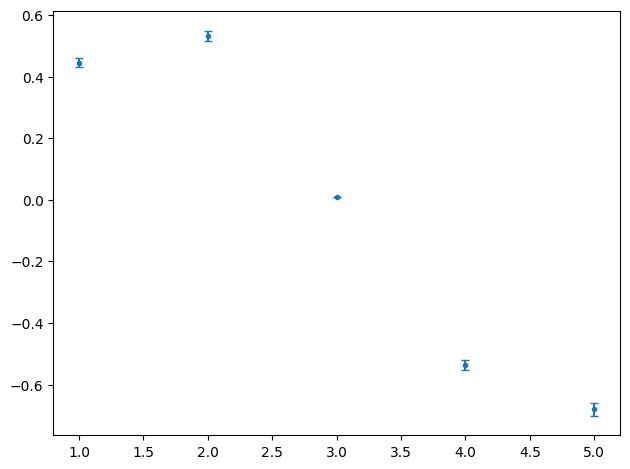

In [219]:
plt.errorbar(np.linspace(1, len(points), len(points)), gv.mean(points), yerr=gv.sdev(points), capsize=3, fmt='.')

In [41]:
q1 = QuantumRegister(1)
q2 = QuantumRegister(1)
qc = QuantumCircuit(q1, q2)
qc.append()

In [ ]:
def build_circuit(nq: int, nsteps, epsilon, mass, init_state=None,
                  dynamic_decoupling=False, Twirling=False,
                  hadronic_current=True):
    
    if hadronic_current:
        # this defines the quantum registers that we are going to use
        # working register of qubits
        qwork = QuantumRegister(nq)
        # the ancilla qubit
        qanc = QuantumRegister(1)
        # classical register for reading working qubits
        cwork = ClassicalRegister(nq)
        # classical register for reading the ancilla bit
        canc = ClassicalRegister(1)
        # this defines the quantum circuit
        qc = QuantumCircuit(qwork, qanc, cwork, canc)
        # this does the state preparation part of the code
        if init_state is None:
            if nq == 3:
                qc.h(qwork[0])
                qc.cx(qwork[0], qwork[1])
                qc.cx(qwork[0], qwork[2])
                qc.x(qwork[2])
                qc.h(qwork[1])
            elif nq == 7:
                qc = QuantumCircuit(nq, nq)
                qc.h(qwork[2])
                qc.cx(qwork[2], qwork[3])
                qc.cx(qwork[3], qwork[4])
                qc.x([qwork[2], qwork[6]])
                qc.h([qwork[1], qwork[3], qwork[5]])
    #             qc = sprep.prepare_states_nsites4(nq)['meson']
        else
            qc.initialize(init_state, qwork)
        
            qc.nsteps
            qc.append(Trot.trotter_evolution(nsites, epsilon, mass, nsteps,
                                    richardson_level=1),
                       [i for i in range(nq)])
    #         for i in range(4):
            return qc
    #         return transpile(qc.decompose(), basis_gates=['cx', 'rz', 'sx'])
        else: